In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os 
from matplotlib.image import imread
import zipfile

#### Unzipping Images 

In [5]:
zip_obj = zipfile.ZipFile("Resources/ailen_Pred.zip", mode="r")

In [6]:
zip_obj.extractall("Resources/")

### Setting Data Dir
- This will be the main directory for the image files we will use for the model

In [7]:
data_dir = "Resources/data/"

In [8]:
os.listdir(data_dir)

['train', 'validation']

### Training and Validation/Testing Set

In [9]:
train_dir = data_dir+"/train"

In [10]:
os.listdir(train_dir)

['alien', 'predator']

## Testing

In [11]:
testing_dir = data_dir+"/validation"

In [12]:
os.listdir(testing_dir)

['alien', 'predator']

### Taking a look at an image for each clasification
- Looking at one alien and one Predator image

In [15]:
os.listdir(train_dir+"/alien")[0]

'0.jpg'

In [17]:
sample_alien_image_path = train_dir+"/alien"+"/0.jpg"

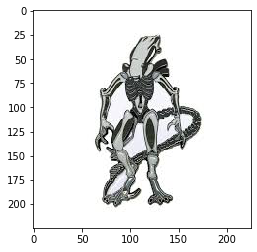

In [19]:
plt.imshow(imread(sample_alien_image_path))

In [26]:
imread(sample_alien_image_path).shape

(225, 225, 3)

In [20]:
sample_pred_image_path = train_dir+"/predator"+"/0.jpg"

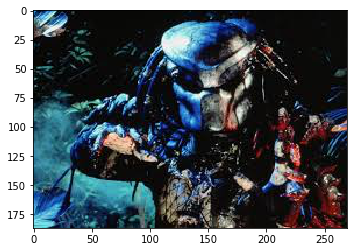

In [22]:
plt.imshow(imread(sample_pred_image_path))

In [28]:
imread(sample_pred_image_path).shape

(187, 270, 3)

### Resizing 
- Our model will need to consider the sizing of the images coming and make sure they are all the same shape
- Let use the at the average image size for one set of images.

In [30]:
dim1 = []
dim2 = []
for image_name in os.listdir(testing_dir+"/alien"):
    img = imread(testing_dir+"/alien/"+image_name)
    d1,d2,c = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [32]:
np.mean(dim1)

203.39

In [33]:
np.mean(dim2)

255.29

### Setting Average size
- This will be the model shape we use for our training

In [34]:
average_img_size = (200,250,3)

### Creating a generator
- Genrator allows us to minipulate the image a bit for better training and accuracy

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
genertor = ImageDataGenerator(
    featurewise_center=False,
    rotation_range=0,
    shear_range=0.1,
    zoom_range=0.4,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255,
)

### Testing Generator is workging
- will randomly randomly transform a sample image 
- run this cell a few times to see generator effect

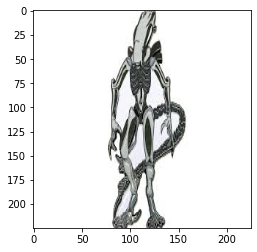

In [54]:
plt.imshow(genertor.random_transform(imread(sample_alien_image_path)))

### Checking if the generator recognizes the class indicies
- We need to make sure the generator is picking up the classes before moving forward
- Below look like this is working perfectly

In [56]:
genertor.flow_from_directory(train_dir)

Found 694 images belonging to 2 classes.


In [57]:
genertor.flow_from_directory(testing_dir)

Found 200 images belonging to 2 classes.


## WE will need aa training generator and a testing generator 
- These will be fitted to the model that we create

In [60]:
train_gen = genertor.flow_from_directory (
    train_dir,
    target_size=average_img_size[:2],
    color_mode='rgb',
    class_mode='binary',
    batch_size=8,
    shuffle=True
)

Found 694 images belonging to 2 classes.


In [61]:
test_gen = genertor.flow_from_directory (
    testing_dir,
    target_size=average_img_size[:2],
    color_mode='rgb',
    class_mode='binary',
    batch_size=8,
    shuffle=False
)

Found 200 images belonging to 2 classes.


## Creating the model
- Lets use a Sequential model with CNN2dLayer along with a few pooling layers 

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Using Early stopping to prevent overtraining 

In [64]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

In [67]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (2,2), strides = (1,1), padding = "same", input_shape = average_img_size,
                activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (2,2), strides = (1,1), padding = "same", input_shape = average_img_size,
                activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (2,2), strides = (1,1), padding = "same", input_shape = average_img_size,
                activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 150, activation = "relu"))
model.add(Dense(units = 50, activation = "relu"))
model.add(Dense(units = 1 , activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

## Fitting the model
 - Weill fit the designed model to the generators we created

In [68]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=10, callbacks=[stop])

Epoch 1/10
87/87 [==============================] - 288s 3s/step - loss: 0.6718 - accuracy: 0.5879 - val_loss: 0.6650 - val_accuracy: 0.5650
Epoch 2/10
87/87 [==============================] - 280s 3s/step - loss: 0.6339 - accuracy: 0.6398 - val_loss: 0.6577 - val_accuracy: 0.6600
Epoch 3/10
87/87 [==============================] - 280s 3s/step - loss: 0.5999 - accuracy: 0.6945 - val_loss: 0.6250 - val_accuracy: 0.6400
Epoch 4/10
87/87 [==============================] - 275s 3s/step - loss: 0.5667 - accuracy: 0.7118 - val_loss: 0.5695 - val_accuracy: 0.7150
Epoch 5/10
87/87 [==============================] - 277s 3s/step - loss: 0.5324 - accuracy: 0.7392 - val_loss: 0.5705 - val_accuracy: 0.7050
Epoch 6/10
87/87 [==============================] - 276s 3s/step - loss: 0.5182 - accuracy: 0.7579 - val_loss: 0.5385 - val_accuracy: 0.7450
Epoch 7/10
87/87 [==============================] - 279s 3s/step - loss: 0.5008 - accuracy: 0.7695 - val_loss: 0.5507 - val_accuracy: 0.7350
Epoch 8/10
87

## Model Evaluation
- Model training is pretty good but we may need to update our parameters for the model 
- we can see the model begins to overtrain around 7 epochs and begins to lose accuracy

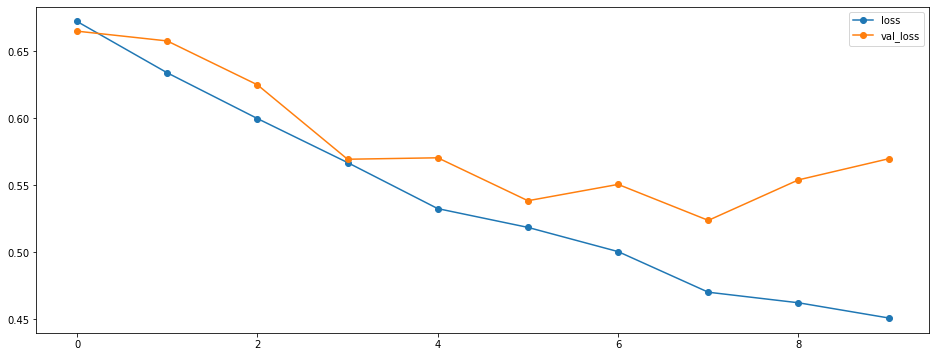

In [74]:
pd.DataFrame(model.history.history)[["loss", 'val_loss']].plot(figsize = (16,6), marker = "o")

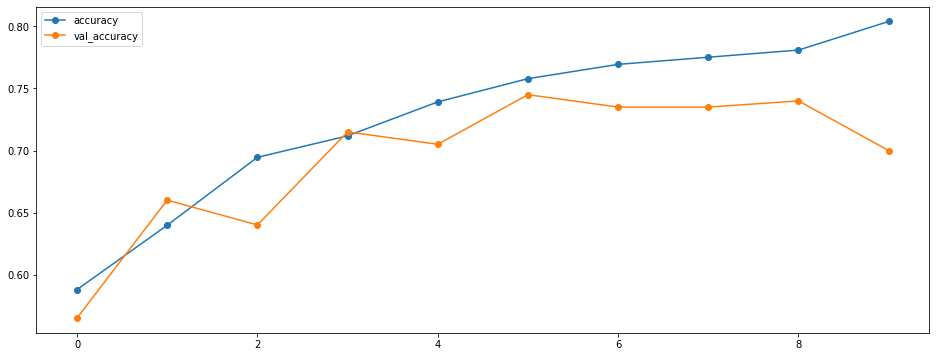

In [75]:
pd.DataFrame(model.history.history)[["accuracy", 'val_accuracy']].plot(figsize = (16,6), marker = "o")

### Testing predictions 
- Lets test the model predictions on the test generator 

In [87]:
predicitons = model.predict(test_gen)

In [92]:
pred = predicitons > 0.5

In [93]:
len(pred)

200

In [96]:
len(test_gen.classes)

200

### Looking at metrics
- willl use sklearn classification report to analyze the predictions
- We have a 71% accuracy in the accuracy for the model 
- it appears that the model predicts predator better than alien - this could be due to image quality or need to pursue a longer training period

In [110]:
pred_dummys = pd.get_dummies(pd.DataFrame(pred, columns=["pred"])["pred"], drop_first=True)

In [116]:
pred_dummys.columns = ["alien"]

In [97]:
from sklearn.metrics import classification_report

In [117]:
print(classification_report(pred_dummys["alien"], test_gen.classes))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68        84
           1       0.79      0.68      0.73       116

    accuracy                           0.71       200
   macro avg       0.71      0.72      0.71       200
weighted avg       0.72      0.71      0.71       200



In [118]:
test_gen.class_indices

{'alien': 0, 'predator': 1}

In [119]:
##model.save("Resources/alien_pred_v1.h5")

In [121]:
##pd.DataFrame(model.history.history).to_csv("Resources/model_trainingHistory.csv")